In [1]:
from graphslam.graph import Graph
from graphslam.load import load_g2o_se2

# Introduction

For a complete derivation of the Graph SLAM algorithm, please see [graphSLAM_formulation.pdf](./graphSLAM_formulation.pdf).  

This notebook illustrates the iterative optimization of a real-world $SE(2)$ dataset.  The code can be found in the `graphslam` folder.  For simplicity, numerical differentiation is used in lieu of analytic Jacobians.  This code originated from the [python-graphslam](https://github.com/JeffLIrion/python-graphslam) repo, which is a full-featured Graph SLAM solver.  The dataset in this example is used with permission from Luca Carlone and was downloaded from his [website](https://lucacarlone.mit.edu/datasets/).  

# The Dataset

In [2]:
g = load_g2o_se2("data/input_INTEL.g2o")

print("Number of edges:    {}".format(len(g._edges)))
print("Number of vertices: {}".format(len(g._vertices)))

Number of edges:    1483
Number of vertices: 1228


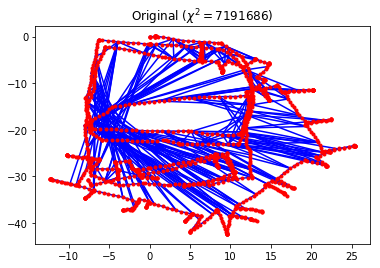

In [3]:
g.plot(title=r"Original ($\chi^2 = {:.0f}$)".format(g.calc_chi2()))

Each edge in this dataset is a constraint that compares the measured $SE(2)$ transformation between two poses to the expected $SE(2)$ transformation between them, as computed using the current pose estimates.  These edges can be classified into two categories:

1. Odometry edges constrain two consecutive vertices, and the measurement for the $SE(2)$ transformation comes directly from odometry data.
2. Scan-matching edges constrain two non-consecutive vertices.  These scan matches can be computed using, for example, 2-D LiDAR data or landmarks; the details of how these contstraints are determined is beyond the scope of this example.  This is often referred to as *loop closure* in the Graph SLAM literature.

We can easily parse out the two different types of edges present in this dataset and plot them.

In [4]:
def parse_edges(g):
    """Split the graph `g` into two graphs, one with only odometry edges and the other with only scan-matching edges.

    Parameters
    ----------
    g : graphslam.graph.Graph
        The input graph

    Returns
    -------
    g_odom : graphslam.graph.Graph
        A graph consisting of the vertices and odometry edges from `g`
    g_scan : graphslam.graph.Graph
        A graph consisting of the vertices and scan-matching edges from `g`

    """
    edges_odom = []
    edges_scan = []
    
    for e in g._edges:
        if abs(e.vertex_ids[1] - e.vertex_ids[0]) == 1:
            edges_odom.append(e)
        else:
            edges_scan.append(e)

    g_odom = Graph(edges_odom, g._vertices)
    g_scan = Graph(edges_scan, g._vertices)

    return g_odom, g_scan

In [5]:
g_odom, g_scan = parse_edges(g)

print("Number of odometry edges:      {:4d}".format(len(g_odom._edges)))
print("Number of scan-matching edges: {:4d}".format(len(g_scan._edges)))

print("\nχ^2 error from odometry edges:       {:11.3f}".format(g_odom.calc_chi2()))
print("χ^2 error from scan-matching edges:  {:11.3f}".format(g_scan.calc_chi2()))

Number of odometry edges:      1227
Number of scan-matching edges:  256

χ^2 error from odometry edges:             0.232
χ^2 error from scan-matching edges:  7191686.151


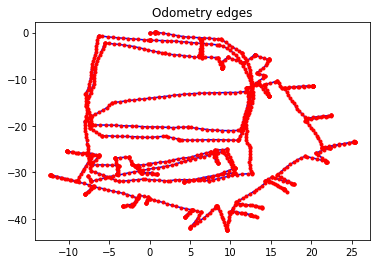

In [6]:
g_odom.plot(title="Odometry edges")

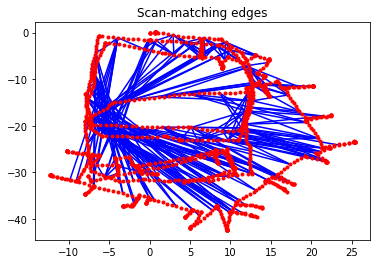

In [7]:
g_scan.plot(title="Scan-matching edges")

# Optimization

Initially, the pose estimates are consistent with the collected odometry measurements, and the odometry edges contribute almost zero towards the $\chi^2$ error.  However, there are large discrepancies between the scan-matching constraints and the initial pose estimates.  This is not surprising, since small errors in odometry readings that are propagated over time can lead to large errors in the robot's trajectory.  What makes Graph SLAM effective is that it allows incorporation of multiple different data sources into a single optimization problem.

In [8]:
g.optimize()


Iteration                chi^2        rel. change
---------                -----        -----------
        0         7191686.3825
        1       320031728.8624          43.500234
        2       125083004.3299          -0.609154
        3          338155.9074          -0.997297
        4             735.1344          -0.997826
        5             215.8405          -0.706393
        6             215.8405          -0.000000


![Graph_SLAM_optimization.gif](images/Graph_SLAM_optimization.gif)

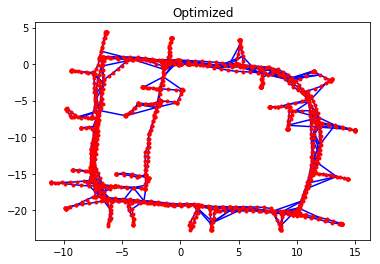

In [9]:
g.plot(title="Optimized")

In [10]:
print("\nχ^2 error from odometry edges:       {:7.3f}".format(g_odom.calc_chi2()))
print("χ^2 error from scan-matching edges:  {:7.3f}".format(g_scan.calc_chi2()))


χ^2 error from odometry edges:       142.189
χ^2 error from scan-matching edges:   73.652


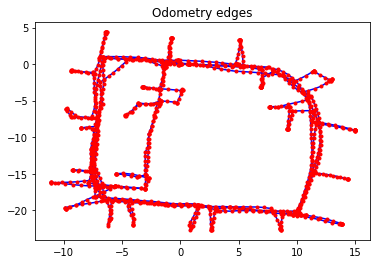

In [11]:
g_odom.plot(title="Odometry edges")

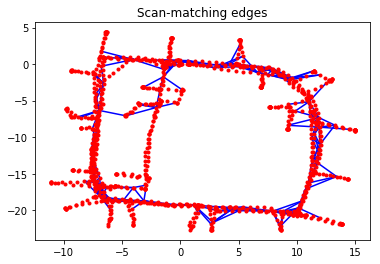

In [12]:
g_scan.plot(title="Scan-matching edges")